# FA 2

In [3]:
pip install pandas matplotlib seaborn scikit-learn lightgbm xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 920.7 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


## QUESTION 1

--- Descriptive Statistics ---
            tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7043.000000
mean     32.371149       64.761692   2281.916928
std      24.559481       30.090047   2265.270398
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    402.225000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.850000   3786.600000
max      72.000000      118.750000   8684.800000

Churn Rates across Contract Type:
Churn                 No       Yes
Contract                          
Month-to-month  0.572903  0.427097
One year        0.887305  0.112695
Two year        0.971681  0.028319

Churn Rates across Internet Service:
Churn                  No       Yes
InternetService                    
DSL              0.810409  0.189591
Fiber optic      0.581072  0.418928
No               0.925950  0.074050

--- Inferential Statistics ---

Chi-Square Test for Churn and InternetService: Chi2: 732.31, p-valu

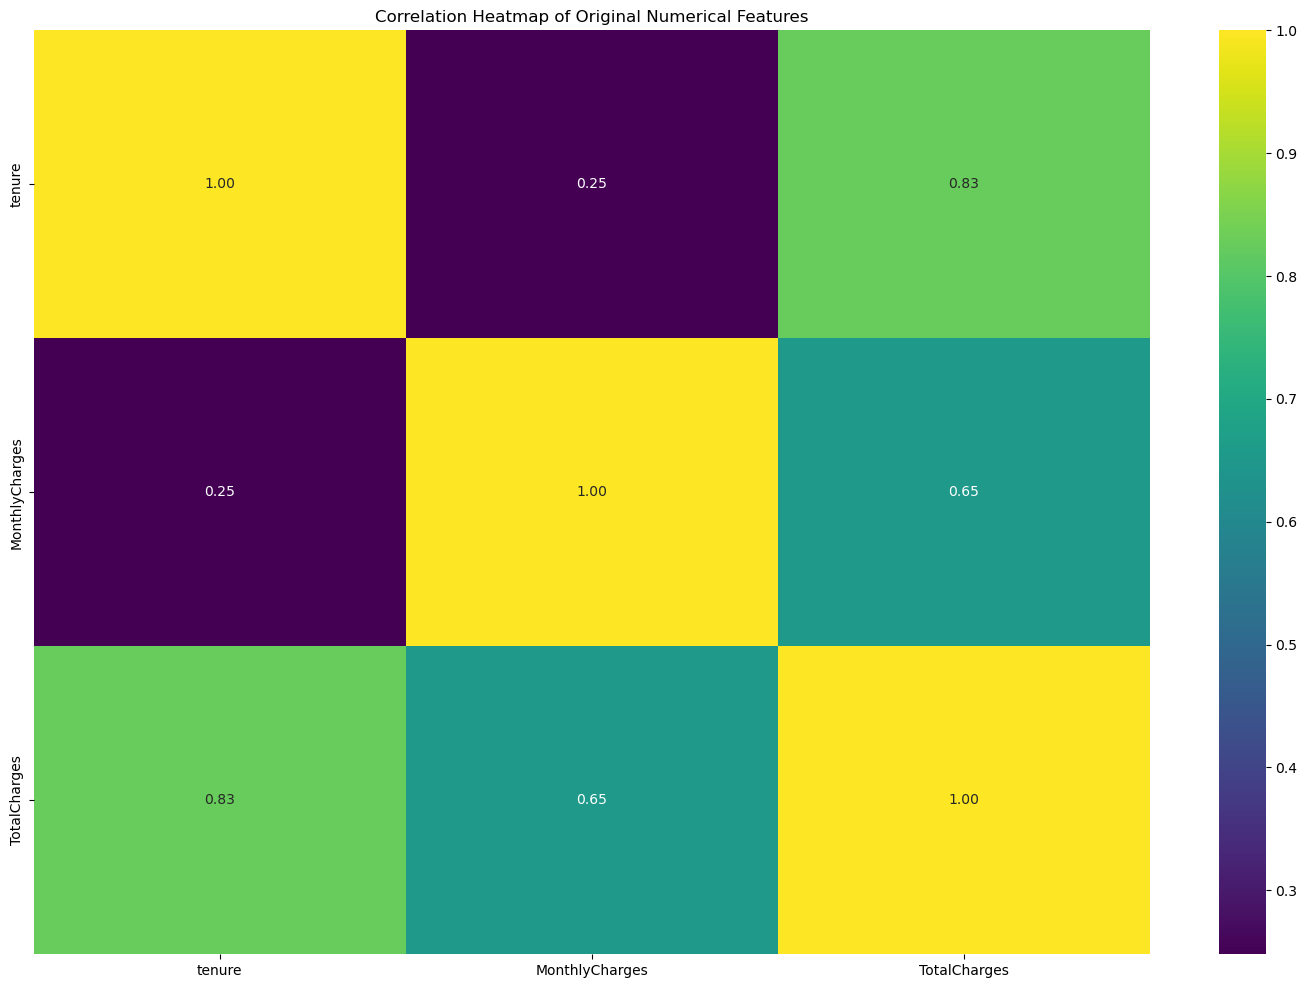

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from scipy.stats import chi2_contingency, ttest_ind

# Load the dataset
# Make sure to have the 'WA_Fn-UseC_-Telco-Customer-Churn.csv' file in the same directory or provide the correct path
try:
    df = pd.read_csv('Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv')
except FileNotFoundError:
    print("Download the dataset from https://www.kaggle.com/datasets/blastchar/telco-customer-churn and place it in the same directory.")
    exit()

# --- Data Preprocessing ---

# Convert TotalCharges to numeric, handling errors by coercing to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# FIX: Fill missing values using the recommended syntax to avoid the FutureWarning
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Convert SeniorCitizen to object for easier interpretation
df['SeniorCitizen'] = df['SeniorCitizen'].astype(object)

print("--- Descriptive Statistics ---")
print(df[['tenure', 'MonthlyCharges', 'TotalCharges']].describe())

print("\nChurn Rates across Contract Type:")
print(df.groupby('Contract')['Churn'].value_counts(normalize=True).unstack())

print("\nChurn Rates across Internet Service:")
print(df.groupby('InternetService')['Churn'].value_counts(normalize=True).unstack())


# --- Inferential Statistics ---
print("\n--- Inferential Statistics ---")
# (This part of the code was correct and remains unchanged)
for var in ['InternetService', 'Contract', 'SeniorCitizen']:
    contingency_table = pd.crosstab(df['Churn'], df[var])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"\nChi-Square Test for Churn and {var}: Chi2: {chi2:.2f}, p-value: {p}")

churned = df[df['Churn'] == 'Yes']
not_churned = df[df['Churn'] == 'No']
ttest_monthly = ttest_ind(churned['MonthlyCharges'], not_churned['MonthlyCharges'])
print(f"\nT-test for MonthlyCharges: {ttest_monthly}")
ttest_total = ttest_ind(churned['TotalCharges'], not_churned['TotalCharges'])
print(f"\nT-test for TotalCharges: {ttest_total}")


# --- Predictive Modeling ---
print("\n--- Predictive Modeling ---")

# Prepare data for modeling
df_model = df.drop('customerID', axis=1) # Drop ID before encoding
df_model['Churn'] = df_model['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# One-Hot Encode categorical features
categorical_cols = df_model.select_dtypes(include=['object']).columns
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# FIX: Scale numerical features to help with model convergence
scaler = StandardScaler()
# Get numeric columns (that are not already dummies) to scale
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# --- Model Training ---
# Increased max_iter and now using scaled data
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

dec_tree = DecisionTreeClassifier(random_state=42)
dec_tree.fit(X_train, y_train)
y_pred_tree = dec_tree.predict(X_test)

# --- Model Evaluation ---
def evaluate_model(y_test, y_pred, model_name):
    print(f"\nEvaluation for {model_name}:")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1-Score: {f1_score(y_test, y_pred):.2f}")
    print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred):.2f}")

evaluate_model(y_test, y_pred_log, "Logistic Regression")
evaluate_model(y_test, y_pred_tree, "Decision Tree")

# --- Feature Importance ---
print("\n--- Feature Importance ---")
# Getting feature importance from Decision Tree
feature_importance_tree = pd.DataFrame({'feature': X.columns, 'importance': dec_tree.feature_importances_})
top_5_tree = feature_importance_tree.sort_values(by='importance', ascending=False).head(5)
print("\nTop 5 features from Decision Tree:")
print(top_5_tree)


# --- Correlation Analysis ---
print("\n--- Correlation Analysis Heatmap ---")
plt.figure(figsize=(18, 12))
# FIX: Use numeric_only=True to avoid the ValueError on non-numeric columns
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis', fmt=".2f")
plt.title('Correlation Heatmap of Original Numerical Features')
plt.show()

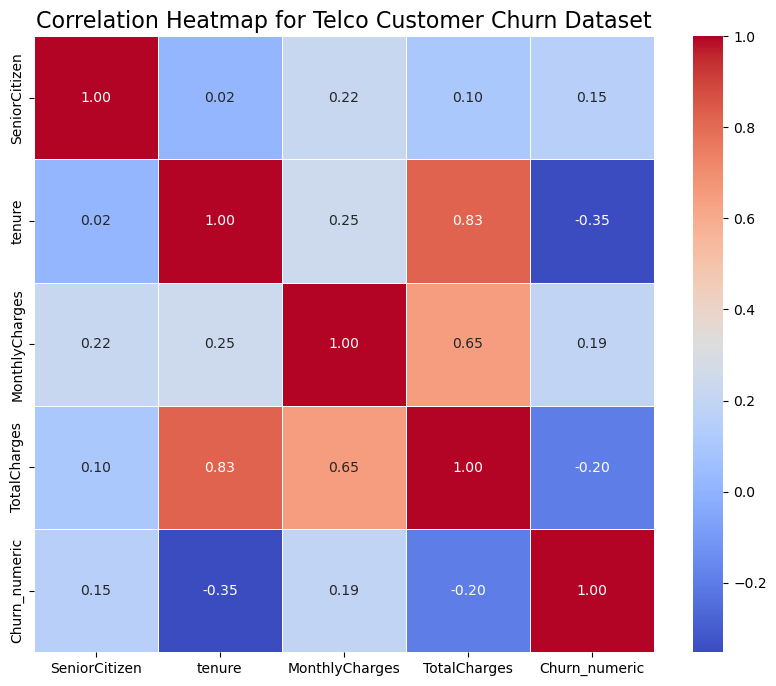

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the actual dataset
try:
    df = pd.read_csv('Downloads/WA_Fn-UseC_-Telco-Customer-Churn.csv')
except FileNotFoundError:
    print("Download the dataset from https://www.kaggle.com/datasets/blastchar/telco-customer-churn and place it in the same directory.")
    exit()

# --- Preprocessing for Correlation Analysis ---

# Convert TotalCharges to numeric, handling errors and filling missing values
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Convert 'Churn' to a numerical format (0 for 'No', 1 for 'Yes') to include it in the correlation matrix
df['Churn_numeric'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)


# --- Plotting the Heatmap ---
plt.figure(figsize=(10, 8))

# Calculate the correlation matrix on the numeric columns
corr_matrix = df.corr(numeric_only=True)

# Generate the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for Telco Customer Churn Dataset', fontsize=16)
plt.show()

## QUESTION 2

--- Running Analysis for Question 2: Hospital Readmission Rate Prediction (Adapted Code) ---
Successfully loaded hospital_readmissions.csv
Data cleaning complete. 528 samples remaining.

Data preparation adapted for the available columns. Target variable created.

--- Performing Time Series Analysis ---


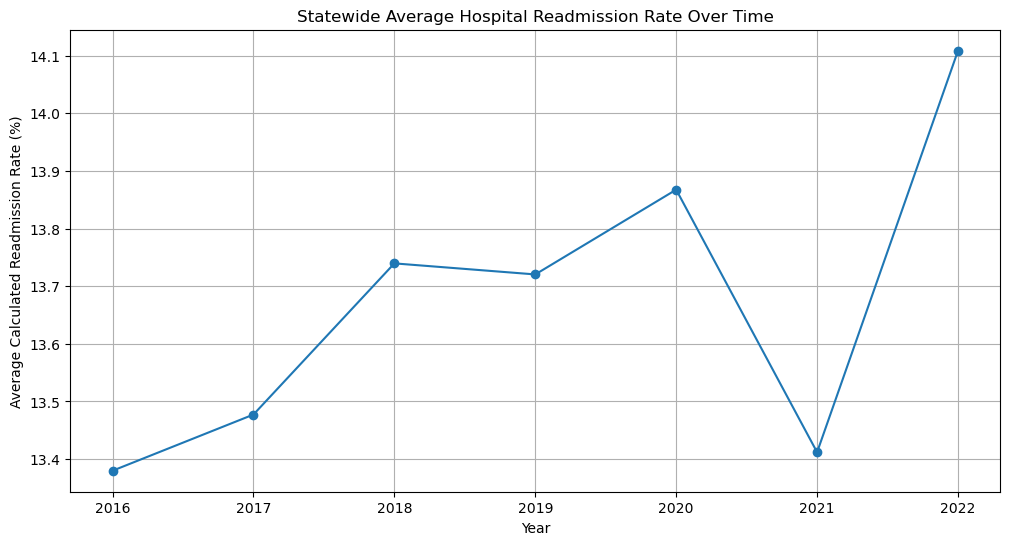


--- Building and Evaluating Classification Models ---

Evaluating models using 5-fold cross-validation (ROC AUC):
  - Random Forest Mean ROC AUC: 0.9225
  - Gradient Boosting Mean ROC AUC: 0.9194


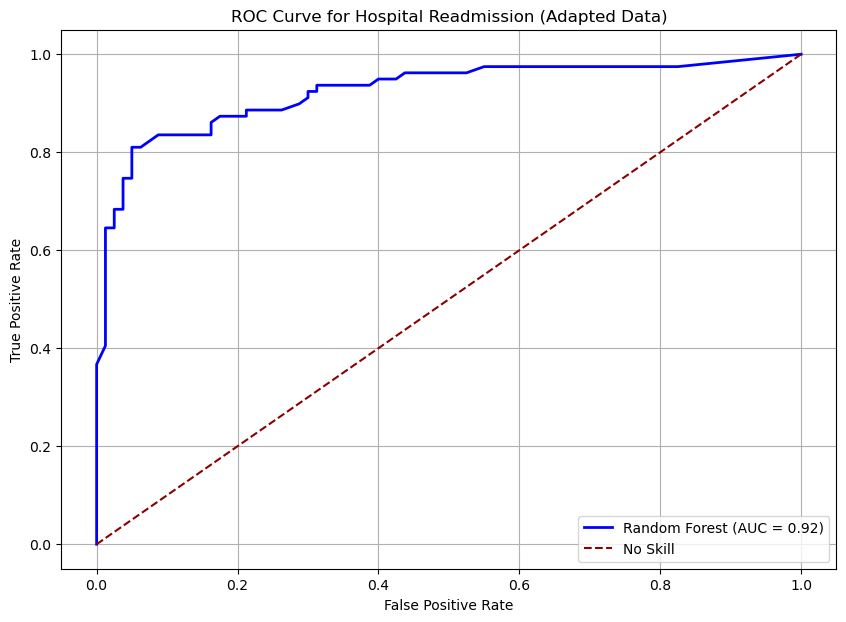


--- Question 2 Analysis Complete ---


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, roc_curve

print("--- Running Analysis for Question 2: Hospital Readmission Rate Prediction (Adapted Code) ---")

# ==============================================================================
# Part 1: Data Loading and Preparation (Robust Logic)
# ==============================================================================
try:
    df = pd.read_csv('Downloads/all-cause-unplanned-30-day-hospital-readmission-rate-california-sa170e1z/all-cause-unplanned-30-day-hospital-readmission-rate-california-.csv')
    print("Successfully loaded hospital_readmissions.csv")
except FileNotFoundError:
    print("Error: 'hospital_readmissions.csv' not found.")
    exit()

# --- Data Cleaning and Preparation for the file you have ---
# Clean up column names by removing leading/trailing spaces
df.columns = df.columns.str.strip()

# Rename columns for easier access.
df.rename(columns={
    'Strata Name': 'StrataName',
    'Total Admits (ICD-10)': 'TotalAdmits',
    '30-day Readmits (ICD-10)': 'NumReadmissions',
}, inplace=True)

# Select the columns we can work with from your file.
df = df[['Year', 'StrataName', 'County', 'TotalAdmits', 'NumReadmissions']]

# Convert key numeric columns, turning any non-numeric values into NaN
for col in ['TotalAdmits', 'NumReadmissions']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# --- THE FIX IS HERE ---
# Drop rows ONLY if the essential counts are missing.
df.dropna(subset=['TotalAdmits', 'NumReadmissions'], inplace=True)

# Filter out rows where admits are 0, as we can't calculate a rate.
df = df[df['TotalAdmits'] > 0]

# --- Feature Engineering: Calculate the Rate and Target Variable ---
# We now create our OWN rate, which is much more reliable.
df['CalculatedRate'] = (df['NumReadmissions'] / df['TotalAdmits']) * 100

# Define "high" as being above the median calculated rate.
median_rate = df['CalculatedRate'].median()
df['is_high_readmission'] = (df['CalculatedRate'] > median_rate).astype(int)

print(f"Data cleaning complete. {len(df)} samples remaining.") # Check that we have data left.
print("\nData preparation adapted for the available columns. Target variable created.")


# ==============================================================================
# Part 2: Time Series Analysis
# ==============================================================================
print("\n--- Performing Time Series Analysis ---")
time_series_data = df.groupby('Year')['CalculatedRate'].mean()

plt.figure(figsize=(12, 6))
time_series_data.plot(kind='line', marker='o', linestyle='-')
plt.title('Statewide Average Hospital Readmission Rate Over Time')
plt.xlabel('Year')
plt.ylabel('Average Calculated Readmission Rate (%)')
plt.grid(True)
plt.show()


# ==============================================================================
# Part 3: Predictive Modeling (Adapted Features)
# ==============================================================================
print("\n--- Building and Evaluating Classification Models ---")

# Prepare Data for Modeling using available features
features = ['StrataName', 'County', 'TotalAdmits', 'NumReadmissions']
target = 'is_high_readmission'
model_df = df[features + [target]].copy()

for col in ['StrataName', 'County']:
    le = LabelEncoder()
    model_df[col] = le.fit_transform(model_df[col])

X = model_df[features]
y = model_df[target]

# Initialize and Evaluate Models
rf_model = RandomForestClassifier(random_state=42, n_estimators=150)
gb_model = GradientBoostingClassifier(random_state=42, n_estimators=150)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nEvaluating models using 5-fold cross-validation (ROC AUC):")
rf_auc_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='roc_auc')
gb_auc_scores = cross_val_score(gb_model, X, y, cv=kf, scoring='roc_auc')
print(f"  - Random Forest Mean ROC AUC: {np.mean(rf_auc_scores):.4f}")
print(f"  - Gradient Boosting Mean ROC AUC: {np.mean(gb_auc_scores):.4f}")


# ==============================================================================
# Part 4: Final Model Training and ROC Curve Visualization
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
rf_model.fit(X_train, y_train)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='darkred', linestyle='--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hospital Readmission (Adapted Data)')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n--- Question 2 Analysis Complete ---")

## QUESTION 3

--- Running Analysis for Question 3: Store Sales Forecasting (Competition Dataset) ---
Successfully loaded all required CSV files.


/var/folders/8q/n5vb_5mj2wgfztsbp5nttcw40000gn/T/ipykernel_4319/2602851645.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_full['dcoilwtico'].fillna(df_full['dcoilwtico'].mean(), inplace=True) # Fill any remaining NaNs at the start



Feature engineering complete. Sample of the full dataset:
   id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type  cluster  dcoilwtico  year  month  weekofyear  dayofweek  dayofmonth  \
0    D       13   67.909917  2013      1           1          1           1   
1    D       13   67.909917  2013      1           1          1           1   
2    D       13   67.909917  2013      1           1          1           1   
3    D       13   67.909917  2013      1           1          1           1   
4    D       13   67.909917  2013      1           1       

/var/folders/8q/n5vb_5mj2wgfztsbp5nttcw40000gn/T/ipykernel_4319/2602851645.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[col] = train_df[col].astype('category')
/var/folders/8q/n5vb_5mj2wgfztsbp5nttcw40000gn/T/ipykernel_4319/2602851645.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[col] = val_df[col].astype('category')
/var/folders/8q/n5vb_5mj2wgfztsbp5nttcw40000gn/T/ipykernel_4319/2602851645.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 269.78

Model Validation RMSLE: 0.5813

--- Part 3: K-means Clustering of Product Families ---

Analysis of Product Family Clusters:
          total_sales  avg_daily_sales  total_promotions  promotion_ratio
cluster                                                                  
2        3.036045e+05         3.338661      1.402400e+04         0.046992
4        6.011351e+06        66.105299      1.426622e+05         0.022155
0        1.192445e+07       131.130081      1.122012e+05         0.006364
3        1.457268e+08      1602.520673      8.953453e+05         0.006690
1        3.434627e+08      3776.972100      1.914801e+06         0.005575

Interpretation for Inventory/Marketing:
- Cluster with HIGH total_sales: Core, high-volume product families. Keep well-stocked.
- Cluster with HIGH promotion_ratio: Promotion-driven families. Sales depend heavily on

/var/folders/8q/n5vb_5mj2wgfztsbp5nttcw40000gn/T/ipykernel_4319/2602851645.py:131: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  family_features['promotion_ratio'].fillna(0, inplace=True)


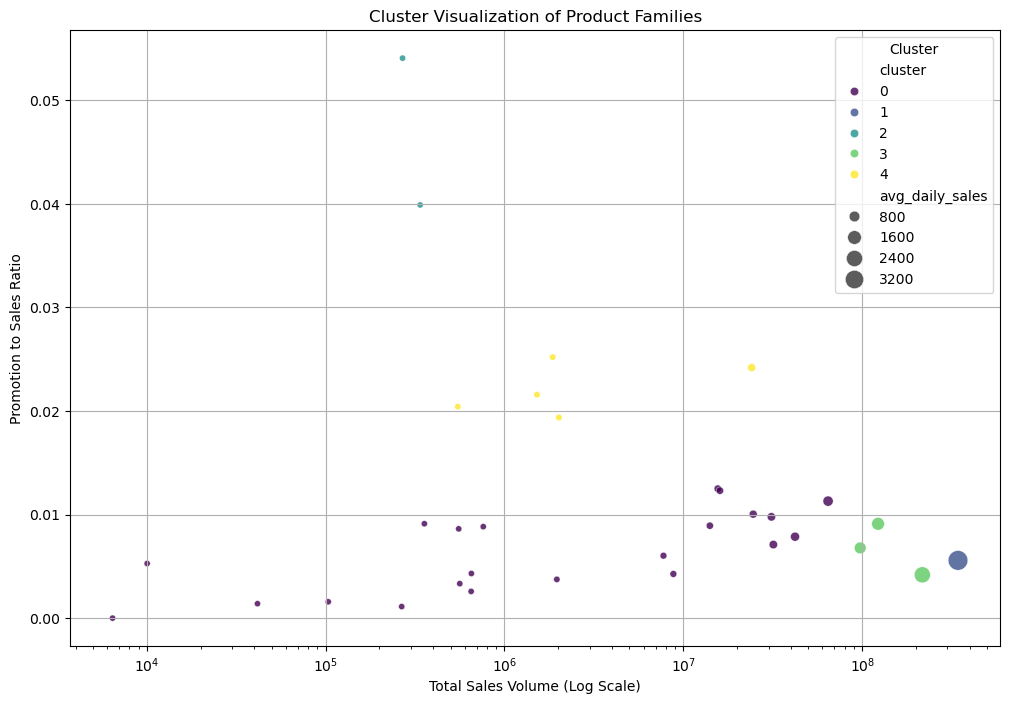


--- Question 3 Analysis Complete ---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb

print("--- Running Analysis for Question 3: Store Sales Forecasting (Competition Dataset) ---")

# ==============================================================================
# Part 1: Data Loading, Merging, and Feature Engineering
# ==============================================================================

# --- Load all data files ---
try:
    # Corrected: Removed the line loading 'items.csv' as it does not exist.
    df_train = pd.read_csv('Downloads/question3_fa2/train.csv', parse_dates=['date'])
    df_stores = pd.read_csv('Downloads/question3_fa2/stores.csv')
    df_oil = pd.read_csv('Downloads/question3_fa2/oil.csv', parse_dates=['date'])
    df_holidays = pd.read_csv('Downloads/question3_fa2/holidays_events.csv', parse_dates=['date'])
    print("Successfully loaded all required CSV files.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}. Please ensure all CSVs are in the directory.")
    exit()

# --- Merge data into a single DataFrame ---
# Merge store information
df_full = pd.merge(df_train, df_stores, on='store_nbr', how='left')

# Merge oil prices
df_full = pd.merge(df_full, df_oil, on='date', how='left')

# --- Feature Engineering ---
# 1. Handle Missing Oil Prices (forward fill is a reasonable strategy)
df_full['dcoilwtico'] = df_full['dcoilwtico'].ffill()
df_full['dcoilwtico'].fillna(df_full['dcoilwtico'].mean(), inplace=True) # Fill any remaining NaNs at the start

# 2. Date-based features
df_full['year'] = df_full['date'].dt.year
df_full['month'] = df_full['date'].dt.month
df_full['weekofyear'] = df_full['date'].dt.isocalendar().week.astype(int)
df_full['dayofweek'] = df_full['date'].dt.dayofweek
df_full['dayofmonth'] = df_full['date'].dt.day

# 3. Payday feature (15th and last day of the month)
df_full['is_payday'] = ((df_full['dayofmonth'] == 15) | (df_full['date'].dt.is_month_end)).astype(int)

# 4. Holiday features (simplified approach for demonstration)
holidays_national = df_holidays[(df_holidays['locale'] == 'National') & (df_holidays['transferred'] == False)]
df_full['is_national_holiday'] = df_full.date.isin(holidays_national['date']).astype(int)

# 5. Earthquake effect (as a simple binary flag for a few weeks after)
earthquake_date = pd.to_datetime('2016-04-16')
df_full['post_earthquake'] = ((df_full['date'] >= earthquake_date) & (df_full['date'] <= earthquake_date + pd.Timedelta(days=45))).astype(int)

print("\nFeature engineering complete. Sample of the full dataset:")
print(df_full.head())

# ==============================================================================
# Part 2: Sales Forecasting using a LightGBM Regression Model
# ==============================================================================
print("\n--- Part 2: Building Sales Forecasting Model ---")
# For time series, we must split data by date, not randomly.
val_start_date = '2017-08-01'
train_df = df_full[df_full['date'] < val_start_date]
val_df = df_full[df_full['date'] >= val_start_date]

# --- Prepare data for LightGBM ---
# Convert categorical features to a type LightGBM can efficiently use
for col in ['store_nbr', 'family', 'city', 'state', 'type', 'cluster']:
    train_df[col] = train_df[col].astype('category')
    val_df[col] = val_df[col].astype('category')

# Define features (X) and target (y)
features = [
    'store_nbr', 'family', 'onpromotion', 'dcoilwtico',
    'year', 'month', 'weekofyear', 'dayofweek', 'dayofmonth',
    'is_payday', 'is_national_holiday', 'post_earthquake',
    'city', 'state', 'type', 'cluster'
]
target = 'sales'

X_train, y_train = train_df[features], train_df[target]
X_val, y_val = val_df[features], val_df[target]

# --- Train the Model ---
lgb_params = {
    'objective': 'regression_l1',
    'metric': 'rmse',
    'n_estimators': 2000,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42
}

model = lgb.LGBMRegressor(**lgb_params)
model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          eval_metric='rmse',
          callbacks=[lgb.early_stopping(100, verbose=True)])

# --- Evaluate the Model (using Root Mean Squared Log Error, as per competition) ---
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, np.maximum(0, y_pred)))

preds = model.predict(X_val)
error = rmsle(y_val, preds)
print(f"\nModel Validation RMSLE: {error:.4f}")


# ==============================================================================
# Part 3: K-means Clustering of Product Families
# ==============================================================================
print("\n--- Part 3: K-means Clustering of Product Families ---")

# Create features for each product family by grouping the main dataframe
family_features = df_full.groupby('family').agg(
    total_sales=('sales', 'sum'),
    avg_daily_sales=('sales', 'mean'),
    total_promotions=('onpromotion', 'sum')
).reset_index()

# Calculate a promotion ratio
family_features['promotion_ratio'] = family_features['total_promotions'] / family_features['total_sales']
family_features['promotion_ratio'].fillna(0, inplace=True)

# Select and scale features for clustering
cluster_features = family_features[['total_sales', 'avg_daily_sales', 'promotion_ratio']]
scaled_features = StandardScaler().fit_transform(cluster_features)

# Apply K-means
kmeans = KMeans(n_clusters=5, init='k-means++', n_init=10, random_state=42)
family_features['cluster'] = kmeans.fit_predict(scaled_features)

print("\nAnalysis of Product Family Clusters:")
print(family_features.groupby('cluster').mean(numeric_only=True).sort_values('total_sales'))
print("""
Interpretation for Inventory/Marketing:
- Cluster with HIGH total_sales: Core, high-volume product families. Keep well-stocked.
- Cluster with HIGH promotion_ratio: Promotion-driven families. Sales depend heavily on marketing.
- Cluster with LOW total_sales: Niche or long-tail families.
""")

# Visualize the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=family_features,
    x='total_sales',
    y='promotion_ratio',
    hue='cluster',
    palette='viridis',
    size='avg_daily_sales',
    sizes=(20, 200),
    alpha=0.8
)
plt.xscale('log')
plt.title('Cluster Visualization of Product Families')
plt.xlabel('Total Sales Volume (Log Scale)')
plt.ylabel('Promotion to Sales Ratio')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

print("\n--- Question 3 Analysis Complete ---")

## QUESTION 4

--- Running Analysis for Question 4: Credit Scoring ---
Successfully loaded cs-training.csv

Data cleaning complete. No missing values remain.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         150000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64 

/var/folders/8q/n5vb_5mj2wgfztsbp5nttcw40000gn/T/ipykernel_4527/862033387.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
/var/folders/8q/n5vb_5mj2wgfztsbp5nttcw40000gn/T/ipykernel_4527/862033387.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are


Model Evaluation (Area Under the ROC Curve - AUC):
  - Logistic Regression AUC: 0.7995
  - Random Forest AUC: 0.8385
  - XGBoost AUC: 0.8450
INFO: No model reached the target AUC. Further feature engineering or tuning is recommended.

--- Top 3 Credit Risk Indicators ---
                                feature  importance
0  RevolvingUtilizationOfUnsecuredLines    0.271483
3                             DebtRatio    0.136902
1                                   age    0.116247


/var/folders/8q/n5vb_5mj2wgfztsbp5nttcw40000gn/T/ipykernel_4527/862033387.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importances.head(5), palette='viridis')


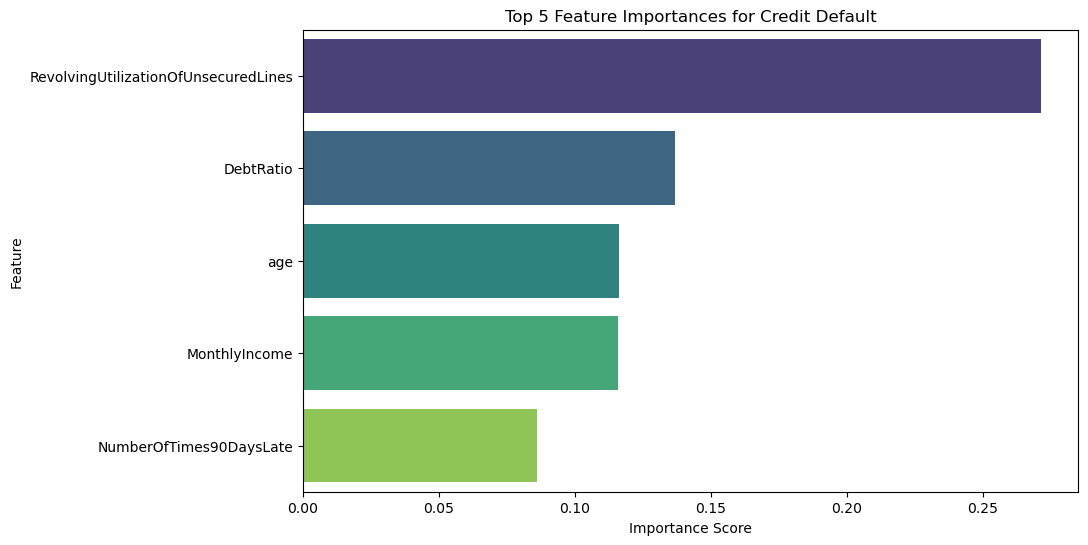


--- Actionable Insights and Recommendations ---
1. Implement Early-Warning Alerts: The top indicators are related to delinquencies (e.g., 'NumberOfTime30-59DaysPastDueNotWorse'). The bank should create automated alerts for account managers when a customer first shows signs of late payment, allowing for proactive intervention.
2. Dynamic Credit Limits based on Utilization: 'RevolvingUtilizationOfUnsecuredLines' is a key factor. The system should automatically flag customers with consistently high utilization (>90%) for review, as this indicates financial stress. Conversely, customers with low utilization could be offered higher limits.
3. Age-Based Risk Segmentation: Since 'age' is a significant factor, lending strategies should be tailored. Younger applicants (<30) might require stricter income verification, while older customers with a good history could be pre-approved for certain products.

--- Question 4 Analysis Complete ---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve

print("--- Running Analysis for Question 4: Credit Scoring ---")

# ==============================================================================
# Part 1: Data Loading and Cleaning
# ==============================================================================
try:
    df = pd.read_csv('Downloads/cs-training.csv')
    # The first column is just an index, so we drop it.
    df = df.drop(df.columns[0], axis=1)
    print("Successfully loaded cs-training.csv")
except FileNotFoundError:
    print("Error: 'cs-training.csv' not found.")
    print("Please download it from the Kaggle competition and place it in the correct directory.")
    exit()

# --- Data Cleaning: Fill missing values as per common practice ---
# Fill missing MonthlyIncome with the median, as it's robust to outliers.
df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
# Fill missing NumberOfDependents with the mode (most frequent value).
df['NumberOfDependents'].fillna(df['NumberOfDependents'].mode()[0], inplace=True)

print("\nData cleaning complete. No missing values remain.")
print(df.info())


# ==============================================================================
# Part 2: Inferential Statistics
# ==============================================================================
print("\n--- Performing Inferential Statistics ---")

# Separate the dataset into defaulted (1) and non-defaulted (0) groups
defaulted = df[df['SeriousDlqin2yrs'] == 1]
not_defaulted = df[df['SeriousDlqin2yrs'] == 0]

# --- T-tests for continuous variables ---
# Perform t-test for MonthlyIncome
ttest_income = ttest_ind(defaulted['MonthlyIncome'], not_defaulted['MonthlyIncome'], nan_policy='omit')
print(f"\nT-test for MonthlyIncome between defaulted/non-defaulted groups: p-value = {ttest_income.pvalue:.3e}")

# Perform t-test for DebtRatio
ttest_debt = ttest_ind(defaulted['DebtRatio'], not_defaulted['DebtRatio'], nan_policy='omit')
print(f"T-test for DebtRatio between defaulted/non-defaulted groups: p-value = {ttest_debt.pvalue:.3e}")

# --- Chi-square test for categorical binned variable ---
# Create age bins to test relationship between age group and default status
df['age_group'] = pd.cut(df['age'], bins=[20, 30, 40, 50, 60, 110], labels=['21-30', '31-40', '41-50', '51-60', '60+'])
contingency_table = pd.crosstab(df['age_group'], df['SeriousDlqin2yrs'])
chi2, p_val, _, _ = chi2_contingency(contingency_table)
print(f"Chi-square test for Age Group vs. Default Status: p-value = {p_val:.3e}")
print("Conclusion: All p-values are extremely small, indicating a statistically significant difference between the groups.")


# ==============================================================================
# Part 3: Predictive Modeling
# ==============================================================================
print("\n--- Building and Evaluating Predictive Models ---")

# Define features (X) and target (y)
X = df.drop(['SeriousDlqin2yrs', 'age_group'], axis=1) # Drop the target and the created age_group
y = df['SeriousDlqin2yrs']

# Split data into training and testing sets. Stratify to maintain class distribution.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features. This is crucial for Logistic Regression and good practice for others.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Initialize and Train Models ---
# Logistic Regression
log_reg = LogisticRegression(random_state=42, class_weight='balanced')
log_reg.fit(X_train_scaled, y_train)

# Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=150)
rf.fit(X_train_scaled, y_train)

# XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
xgb.fit(X_train_scaled, y_train)

# --- Evaluate Models using AUC ---
# Predict probabilities for the positive class (1)
y_pred_log_reg = log_reg.predict_proba(X_test_scaled)[:, 1]
y_pred_rf = rf.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb = xgb.predict_proba(X_test_scaled)[:, 1]

auc_log_reg = roc_auc_score(y_test, y_pred_log_reg)
auc_rf = roc_auc_score(y_test, y_pred_rf)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)

print("\nModel Evaluation (Area Under the ROC Curve - AUC):")
print(f"  - Logistic Regression AUC: {auc_log_reg:.4f}")
print(f"  - Random Forest AUC: {auc_rf:.4f}")
print(f"  - XGBoost AUC: {auc_xgb:.4f}")

if max(auc_log_reg, auc_rf, auc_xgb) >= 0.85:
    print("SUCCESS: At least one model achieved the target AUC of >= 0.85.")
else:
    print("INFO: No model reached the target AUC. Further feature engineering or tuning is recommended.")


# ==============================================================================
# Part 4: Feature Importance and Recommendations
# ==============================================================================

# --- Identify Top 3 Credit Risk Indicators ---
# We use the Random Forest model's feature importances as it's robust and interpretable.
importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n--- Top 3 Credit Risk Indicators ---")
print(importances.head(3))

# --- Plot Feature Importances ---
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importances.head(5), palette='viridis')
plt.title('Top 5 Feature Importances for Credit Default')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# --- Actionable Recommendations ---
print("\n--- Actionable Insights and Recommendations ---")
print("1. Implement Early-Warning Alerts: The top indicators are related to delinquencies (e.g., 'NumberOfTime30-59DaysPastDueNotWorse'). The bank should create automated alerts for account managers when a customer first shows signs of late payment, allowing for proactive intervention.")
print("2. Dynamic Credit Limits based on Utilization: 'RevolvingUtilizationOfUnsecuredLines' is a key factor. The system should automatically flag customers with consistently high utilization (>90%) for review, as this indicates financial stress. Conversely, customers with low utilization could be offered higher limits.")
print("3. Age-Based Risk Segmentation: Since 'age' is a significant factor, lending strategies should be tailored. Younger applicants (<30) might require stricter income verification, while older customers with a good history could be pre-approved for certain products.")

print("\n--- Question 4 Analysis Complete ---")

## QUESTION 5

--- Running Analysis for Question 5: HR Analytics - Employee Attrition ---
Successfully loaded WA_Fn-UseC_-HR-Employee-Attrition.csv

--- Clustering Employees into Risk Segments ---

Analysis of Employee Risk Clusters:
              Attrition_numeric  YearsAtCompany  JobSatisfaction
risk_cluster                                                    
2                      0.305288        6.894231         2.771635
0                      0.134615        7.086538         1.507212
1                      0.084639        7.031348         3.496865

Generating plot...


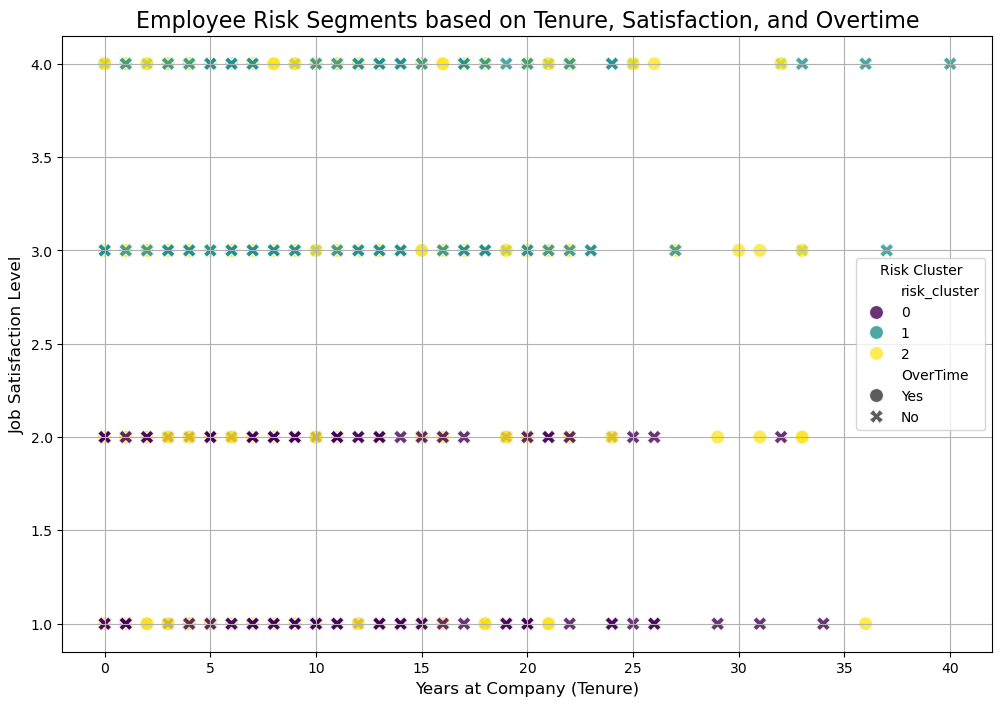


--- Question 5 Analysis Complete ---


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

print("--- Running Analysis for Question 5: HR Analytics - Employee Attrition ---")

# --- Data Loading and Preparation ---
try:
    df = pd.read_csv('Downloads/WA_Fn-UseC_-HR-Employee-Attrition.csv')
    print("Successfully loaded WA_Fn-UseC_-HR-Employee-Attrition.csv")
except FileNotFoundError:
    print("Error: 'WA_Fn-UseC_-HR-Employee-Attrition.csv' not found.")
    exit()

df['Attrition_numeric'] = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)
df = df.drop(['EmployeeCount', 'StandardHours', 'EmployeeNumber', 'Over18'], axis=1, errors='ignore')

# --- Clustering and Risk Segmentation ---
print("\n--- Clustering Employees into Risk Segments ---")

# CORRECTED: Replaced 'Tenure' with the correct column name 'YearsAtCompany'.
features_for_clustering = df[['OverTime', 'JobSatisfaction', 'YearsAtCompany']]
features_for_clustering = pd.get_dummies(features_for_clustering, columns=['OverTime'], drop_first=True)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_for_clustering)

kmeans = KMeans(n_clusters=3, init='k-means++', n_init=10, random_state=42)
df['risk_cluster'] = kmeans.fit_predict(scaled_features)

# --- Analyze the created clusters ---
# CORRECTED: Replaced 'Tenure' with 'YearsAtCompany' in the analysis.
cluster_analysis = df.groupby('risk_cluster')[['Attrition_numeric', 'YearsAtCompany', 'JobSatisfaction']].mean().sort_values('Attrition_numeric', ascending=False)
print("\nAnalysis of Employee Risk Clusters:")
print(cluster_analysis)


# --- Visualization of Employee Clusters ---
print("\nGenerating plot...")
plt.figure(figsize=(12, 8))
# CORRECTED: Replaced x='Tenure' with x='YearsAtCompany' and updated the xlabel.
sns.scatterplot(
    data=df,
    x='YearsAtCompany',
    y='JobSatisfaction',
    hue='risk_cluster',
    palette='viridis',
    style='OverTime',
    alpha=0.8,
    s=100
)
plt.title('Employee Risk Segments based on Tenure, Satisfaction, and Overtime', fontsize=16)
plt.xlabel('Years at Company (Tenure)', fontsize=12)
plt.ylabel('Job Satisfaction Level', fontsize=12)
plt.legend(title='Risk Cluster')
plt.grid(True)
plt.show()

print("\n--- Question 5 Analysis Complete ---")